In [ ]:
import nltk
nltk.download('stopwords')
#STOP_WORDS = stopwords.words('english')
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packa

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Machine Learning/Real World Problem-2/training_variants2")
print("Number of data points : ", data.shape[0])
print("Number of features : ", data.shape[1])
print("Features : ", data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
data_text = pd.read_csv("/content/drive/My Drive/Machine Learning/Real World Problem-2/training_text2",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print("Number of data points : " ,data_text.shape[0])
print("Number of features : ",data_text.shape[1])
print("Features : ",data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
#Preprocessing data

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ',total_text)
        total_text = re.sub('\s+',' ',total_text)
        total_text = total_text.lower()

        for word in total_text.split():
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string


In [ ]:
#Find null description of id with calculated time

start_time = time.clock()
for index, row in data_text.iterrows():

    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407


In [ ]:
#We are merging variatin with gene..

result = pd.merge(data, data_text, on='ID', how='left')
result.head()

In [ ]:
#Seeing null description

result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
#Fill-up null description with gnea+variation of their ID

result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene']+' '+result['Variation']
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


In [ ]:
#In y_true, we have kept all values of class and if in gene and variation has more than single word then we have added all word with "_".

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size = 0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print("Number of data points in train data: ", train_df.shape[0])
print("Number of data points in test data: ", test_df.shape[0])
print("Number of data points in cross validation data: ", cv_df.shape[0])

Number of data points in train data:  2124
Number of data points in test data:  665
Number of data points in cross validation data:  532


In [ ]:
print(train_df)

        ID    Gene  ... Class                                               TEXT
1845  1845   PPP6C  ...     4  mutations ppp6c catalytic subunit protein phos...
1035  1035    TSC2  ...     1  tuberous sclerosis complex tsc autosomal domin...
2777  2777   BRCA2  ...     6  twenty percent individuals strong family perso...
2775  2775   BRCA2  ...     1  assessing impact variants unknown significance...
2080  2080    TET2  ...     1  tet proteins oxidize 5 methylcytosine 5mc dna ...
...    ...     ...  ...   ...                                                ...
2919  2919  NFE2L2  ...     7  nrf2 nuclear factor erythroid 2 nf e2 related ...
2304  2304    JAK1  ...     7  cell acute lymphoblastic leukemia aggressive l...
59      59   PTPRT  ...     1  cancers characterized increased stat3 activati...
1410  1410   FGFR3  ...     7  fgf receptor 3 fgfr3 activated mutation expres...
2337  2337    JAK2  ...     6  myeloproliferative neoplasms mpns group hemato...

[2124 rows x 5 columns]


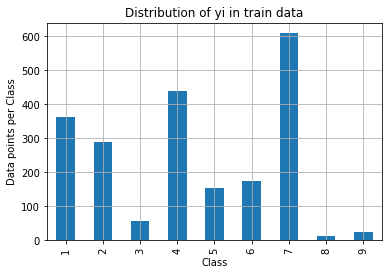

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


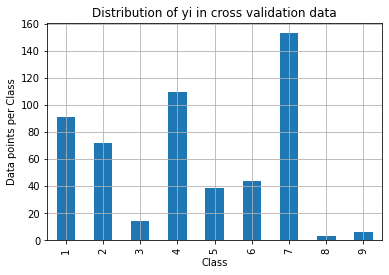

Number of data points in class 7 : 191 ( 35.902 %)
Number of data points in class 4 : 137 ( 25.752 %)
Number of data points in class 1 : 114 ( 21.429 %)
Number of data points in class 2 : 91 ( 17.105 %)
Number of data points in class 6 : 55 ( 10.338 %)
Number of data points in class 5 : 48 ( 9.023 %)
Number of data points in class 3 : 18 ( 3.383 %)
Number of data points in class 9 : 7 ( 1.316 %)
Number of data points in class 8 : 4 ( 0.752 %)
--------------------------------------------------------------------------------


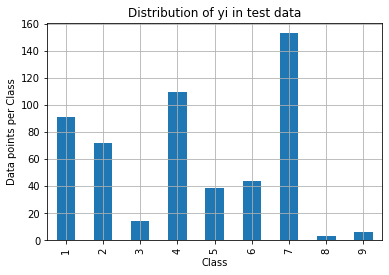

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [ ]:
#%(percentage of each class for train, test and cv data)

train_class_distribution = train_df['Class'].value_counts().sort_index() #Total number of data for each class
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors  = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values) #Descending order of index by total number of data for each class in train_class_distribution
for i in sorted_yi:
    print("Number of data points in class", i+1, ':', train_class_distribution.values[i],'(',np.round((train_class_distribution.values[i]/train_df.shape[0]*100),3),'%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ":", test_class_distribution.values[i],'(',np.round((test_class_distribution.values[i]/cv_df.shape[0]*100),3),'%)')


print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-cv_class_distribution.values) #[6 3 0 1 5 4 2 8 7]
for i in sorted_yi:
    print('Number of data points in class', i+1,':', cv_class_distribution.values[i],'(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100),3),'%)')

In [ ]:
print(sorted_yi)

[6 3 0 1 5 4 2 8 7]


In [ ]:
#Creating confusion matrix function

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()

    print("-"*20, "Precision matrix (Column Sum=1)","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()

    print("-"*20, "Recall matrix (Row sum=1)","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap = "YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()

In [ ]:

cv_data_len = cv_df.shape[0]
cv_predicted_y = np.zeros((cv_data_len,9))
print(cv_data_len)
print(cv_predicted_y)

532
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
rand_probs = np.random.rand(1,9)
print(rand_probs)
"""[[0.59466434 0.16058724 0.44936082 0.00275991 0.07955491 0.58444405
  0.02223588 0.09583201 0.90163725]]"""

[[0.36002131 0.12925286 0.76784218 0.13457223 0.2326773  0.1853122
  0.03903808 0.38875914 0.69091181]]


'[[0.59466434 0.16058724 0.44936082 0.00275991 0.07955491 0.58444405\n  0.02223588 0.09583201 0.90163725]]'

In [ ]:
cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(cv_predicted_y[i])
"""[0.2056896  0.05554583 0.15543028 0.00095463 0.0275174  0.20215448
 0.00769121 0.03314752 0.31186905]"""

[0.12294184 0.0441379  0.26220651 0.04595439 0.07945579 0.06328132
 0.01333091 0.13275538 0.23593596]


'[0.2056896  0.05554583 0.15543028 0.00095463 0.0275174  0.20215448\n 0.00769121 0.03314752 0.31186905]'

Log loss on Cross Validation Data using Random Model 2.509637994979488
Logg loss on Test Data using Random Model 2.4625789364043458
-------------------- Confusion matrix --------------------


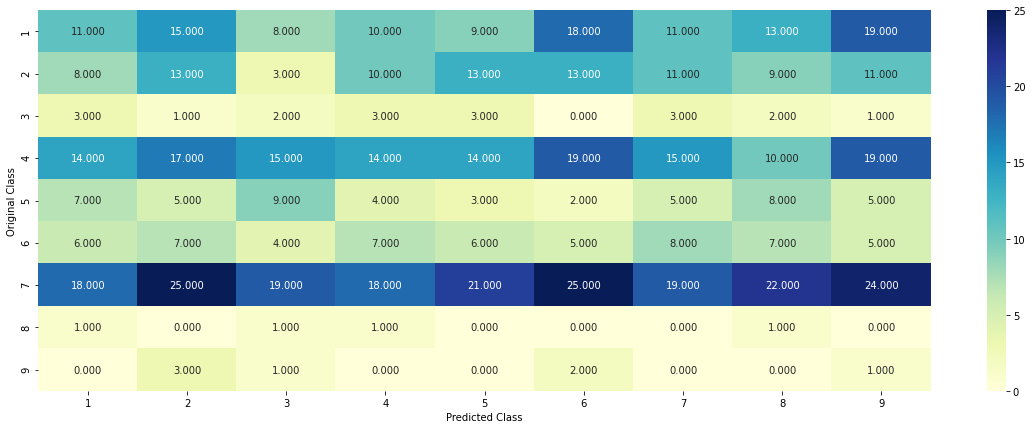

-------------------- Precision matrix (Column Sum=1) --------------------


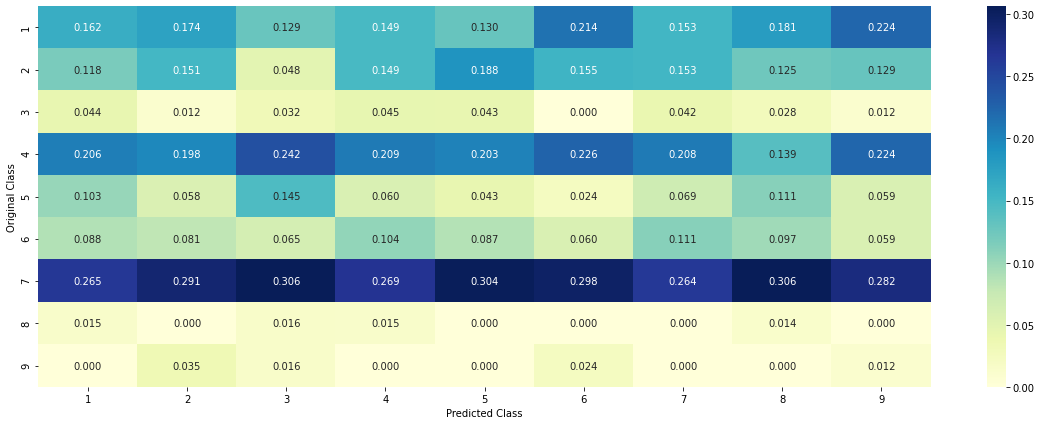

-------------------- Recall matrix (Row sum=1) --------------------


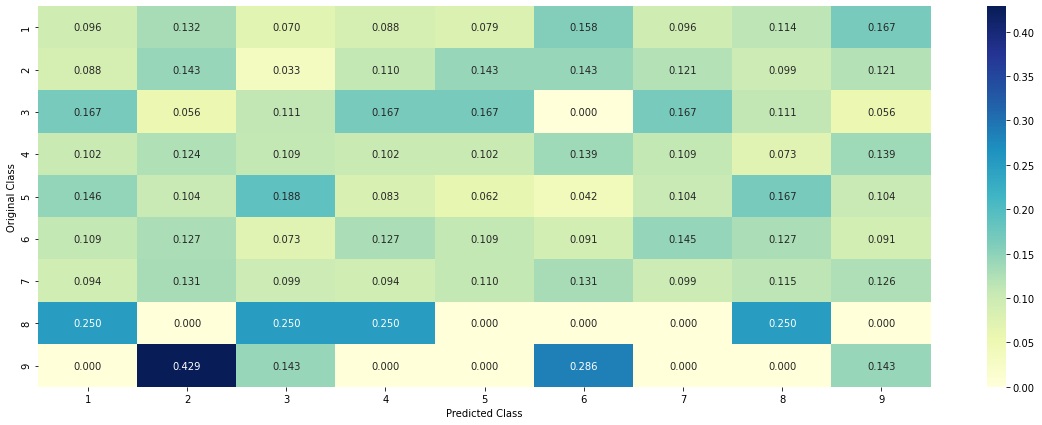

In [ ]:
#Random model

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv, cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Logg loss on Test Data using Random Model", log_loss(y_test, test_predicted_y, eps= 1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [ ]:
for i, denominator in train_df['Gene'].value_counts().items():
    print(i," ",denominator)
"""SPOP   14
PTPN11   14
SMO   14
NTRK1   14
TET2   14
PTPRT   14
AKT1   14
NF1   13
IDH1   13
AR   12
JAK1   12
PMS2   12
SMAD2   12
ESR1   11
TSC1   11
........
MDM2   1
BARD1   1"""

In [ ]:
print(train_df['Gene'].value_counts())
"""BRCA1     162
TP53      112
EGFR       89
BRCA2      88
PTEN       85
         ... 
ATR         1
ARID5B      1
RYBP        1
MDM2        1
BARD1       1
Name: Gene, Length: 238, dtype: int64"""

In [ ]:
#Creating response coding vector

def get_gv_fea_dict(alpha, feature, df):    #For all data
    value_count = train_df[feature].value_counts()
    gv_dict = dict()

    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/(denominator + 90*alpha))
        
        gv_dict[i] = vec
    return gv_dict

def get_gv_feature(alpha, feature, df): #For Train, CV, Test data

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()

    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print("Number of Unique Genes :", unique_genes.shape[0])
print(unique_genes.head(10))
"""Number of Unique Genes : 238
BRCA1     162
TP53      112
EGFR       89
BRCA2      88
PTEN       85
BRAF       63
KIT        60
ERBB2      46
PDGFRA     42
PIK3CA     42
Name: Gene, dtype: int64"""



In [ ]:
print("Ans: There are", unique_genes.shape[0], "different categories of genes in the train data, and they are distributed as follows",)


Ans: There are 235 different categories of genes in the train data, and they are distributed as follows


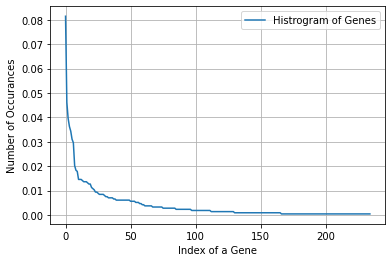

In [ ]:
#Plot pdf for unique genes

s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histrogram of Genes")
plt.xlabel("Index of a Gene")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

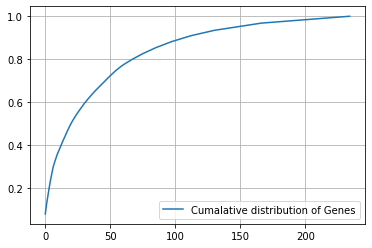

In [ ]:
#Plot cdf for unique genes

c = np.cumsum(h)
plt.plot(c, label = 'Cumalative distribution of Genes')
plt.grid()
plt.legend()
plt.show()


In [ ]:
#Calling functiont to create response coding vector 

alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 'Gene', train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))


In [ ]:
print("train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature: (2124, 9)


In [ ]:
#Creating one-hot encoding vector

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
print('train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:', train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 235)


For values of alpha =  1e-05 The log loss is: 1.220676730447902
For values of alpha =  0.0001 The log loss is: 1.2003095268168489
For values of alpha =  0.001 The log loss is: 1.2370646407592372
For values of alpha =  0.01 The log loss is: 1.3377494151405178
For values of alpha =  0.1 The log loss is: 1.4378428284248859
For values of alpha =  1 The log loss is: 1.4804010659587874


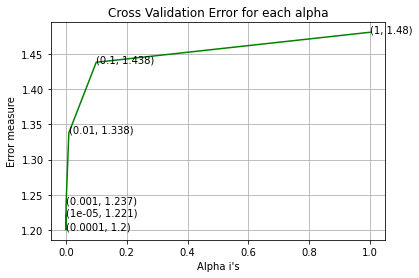

For values of best alpha =  0.0001 The train log loss is: 0.9903422707128745
For values of best alpha =  0.0001 The cross validation log loss is: 1.2003095268168489
For values of best alpha =  0.0001 The test log loss is: 1.1567618187376112


In [ ]:
#Logistic Regression model

alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss = 'log', random_state = 42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ',i,'The log loss is:', log_loss(y_cv, predict_y, labels = clf.classes_, eps=1e-15))

Fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error_array[i]))

plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss = 'log',random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels = clf.classes_, eps = 1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels = clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))

In [ ]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data', test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of ', cv_df.shape[0],':', (cv_coverage/cv_df.shape[0])*100)


Q6. How many data points in Test and CV datasets are covered by the  235  genes in train dataset?
Ans
1. In test data 641 out of 665 : 96.39097744360903
2. In cross validation data 514 out of  532 : 96.61654135338345


In [ ]:
#Variation

unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 1918
Truncating_Mutations    61
Deletion                51
Amplification           46
Fusions                 23
Overexpression           4
E17K                     3
F28L                     2
G12D                     2
G12A                     2
G67R                     2
Name: Variation, dtype: int64


In [ ]:
print("Ans: There are", unique_variations.shape[0], 'different categories of variations in the train data, and they are distributed as follows')


Ans: There are 1918 different categories of variations in the train data, and they are distributed as follows


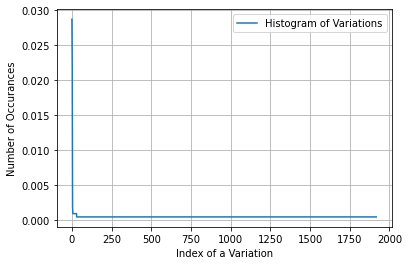

In [ ]:
s = sum(unique_variations.values)
h = unique_variations.values/s
plt.plot(h, label='Histogram of Variations')
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.0287194  0.0527307  0.07438795 ... 0.99905838 0.99952919 1.        ]


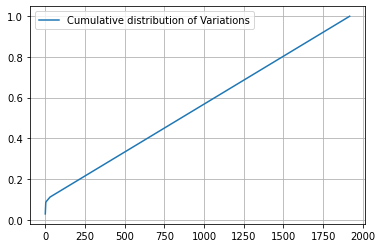

In [ ]:
c = np.cumsum(h)
print(c)
plt.plot(c, label = 'Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [ ]:
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha,'Variation', cv_df))

In [ ]:
print('train_variation_feature_responseCoding is converted feature using the response coding method. The shape of Variation feature:', train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [ ]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
print('train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:', train_variation_feature_onehotCoding.shape)


train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1951)


In [ ]:
a = train_df.head(12)
alamin = variation_vectorizer.fit_transform(a['Gene'])
print(alamin.shape)

(12, 11)


In [ ]:
b = train_df.head(12)
yamin = variation_vectorizer.fit(b['Gene'])


In [ ]:
print(yamin)

"""CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)"""

In [ ]:
c = train_df.head(12)
ruhul = variation_vectorizer.transform(c['Gene'])

In [ ]:
print(ruhul)
""" (0, 1)	1
  (1, 3)	1
  (2, 5)	1
  (3, 7)	1
  (4, 8)	1
  (5, 9)	1
  (6, 1)	1
  (7, 10)	1
  (8, 0)	1
  (9, 4)	1
  (10, 2)	1
  (11, 6)	1"""

  (0, 1)	1
  (1, 3)	1
  (2, 5)	1
  (3, 7)	1
  (4, 8)	1
  (5, 9)	1
  (6, 1)	1
  (7, 10)	1
  (8, 0)	1
  (9, 4)	1
  (10, 2)	1
  (11, 6)	1


In [ ]:
print(alamin)
"""(0, 0)	1 #1st 0 means which row our feature comes from. #2nd 0 means it is our 1st feature by sortest alphabetically or numerialy.
  (1, 12)	1
  (2, 1)	1 #"NIN-PDGFRB_Fusion" there is two feature, MIN and PDGFRB_Fusion. Our function separates words with"-"
  (3, 2)	1
  (4, 9)	1
  (5, 10)	1
  (6, 4)	1
  (7, 8)	1
  (8, 5)	1
  (9, 11)	1
  (10, 3)	1
  (11, 6)	1
  (11, 7)	1"""

In [ ]:
print(a['Variation'])

"""2733                   F468C
2879                  W2626C
2033                    F57V
2242                   G165V
1903                   R978*
2043    Truncating_Mutations
2765                   K499E
437                    R290G
1508                  L1122V
253                    V769M
2576                  G1770V
933        NIN-PDGFRB_Fusion
Name: Variation, dtype: object"""

For values of alpha =  1e-05 The log loss is: 1.7033972037761342
For values of alpha =  0.0001 The log loss is: 1.6976323173440016
For values of alpha =  0.001 The log loss is: 1.7008462703047758
For values of alpha =  0.01 The log loss is: 1.7045076194446875
For values of alpha =  0.1 The log loss is: 1.7183652487832415
For values of alpha =  1 The log loss is: 1.7193107765639366


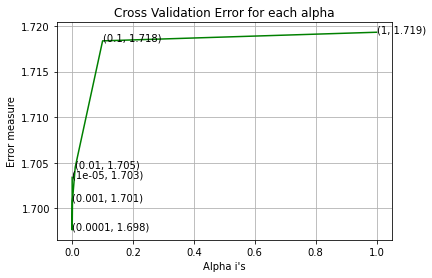

For values of best alpha =  0.0001 The train log loss is: 0.6902572462484203
For values of best alpha =  0.0001 The cross validation log loss is: 1.6976323173440016
For values of best alpha =  0.0001 The test log loss is: 1.7084861773582063


In [ ]:
#Logistic Regression for variation feature

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state = 42)
    clf.fit(train_variation_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels = clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, 'The log loss is:', log_loss(y_cv, predict_y, labels = clf.classes_, eps=1e-15))

fig, ax=plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel('Error measure')
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method ='sigmoid')
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels = clf.classes_, eps = 1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], 'The cross validation log loss is:',log_loss(y_cv, predict_y, labels = clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], 'The test log loss is:', log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))

In [ ]:
"""How many variation of test_df and CV_df in train_df"""

print("Q12. How many data points are covered by total ", unique_variations.shape[0], " Variation in test and cross validation data sets?")
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans/n1. In test data', test_coverage, 'out of', test_df.shape[0], ':',(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of ',cv_df.shape[0], ':', (cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1918  Variation in test and cross validation data sets?
Ans/n1. In test data 57 out of 665 : 8.571428571428571
2. In cross validation data 55 out of  532 : 10.338345864661653


In [ ]:
#Create dictionary for TEXT data. This function will be called from "dict_list" function...


def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

#Create response coding vector

In [ ]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90))) #With calling dict_list
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

""">>> counts = { 'chuck' : 1 , 'annie' : 42, 'jan': 100}
>>> print counts.get('jan', 0)
100
>>> print counts.get('tim', 0)
0 """

">>> counts = { 'chuck' : 1 , 'annie' : 42, 'jan': 100}\n>>> print counts.get('jan', 0)\n100\n>>> print counts.get('tim', 0)\n0 "

#Create one hot coding vector

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53712


matrix([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
x.getA1()
array([ 0,  1,  2, ...,  9, 10, 11])

In [ ]:
print(text_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [ ]:
import operator
print(max(text_fea_dict.items(), key=operator.itemgetter(1))[0])
print(text_fea_dict['mutations'])

mutations
150752


In [ ]:
print(text_fea_dict)

{'00': 2442, '000': 5679, '0000': 8, '00000001': 6, '0000001': 11, '000001': 18, '000002': 10, '000003': 3, '000007': 11, '000009': 3, '00001': 23, '000011': 3, '0000112': 3, '000012': 3, '000017': 4, '0000208': 6, '00002644': 7, '00005': 8, '000059': 3, '00006': 4, '0000614': 6, '0000645': 3, '00006559': 3, '000077': 54, '0000839': 3, '00009': 6, '0001': 1508, '0001042': 6, '0001171': 3, '000132': 22, '000141': 11, '00016': 5, '000179': 13, '000182': 5, '00019': 4, '0002': 133, '0002050': 3, '0002079': 3, '0002158': 12, '00023490': 3, '000245': 13, '000249': 16, '000251': 15, '000258': 24, '000267': 57, '00028': 5, '00029': 7, '0003': 77, '0003073': 3, '0003254': 3, '00034': 4, '0003529': 3, '000369266': 28, '00037': 4, '0004': 66, '0004376': 3, '0004798': 3, '0004920': 3, '0005': 76, '0005044': 3, '0005159': 3, '0005214': 3, '0005266': 3, '0005309': 3, '000535': 11, '0005355': 3, '000546': 3, '000548': 61, '000588': 24, '0006': 45, '0007': 30, '0008': 214, '00088': 7, '0009': 24, '00

In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
total_dict = extract_dictionary_paddle(train_df)


In [ ]:
print(type(dict_list))

<class 'list'>


In [ ]:
#Create response coding of text features with calling function
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
print(train_text_feature_responseCoding)

[[0.16153843 0.08549899 0.02292012 ... 0.18315869 0.00774574 0.01305634]
 [0.13202893 0.10746318 0.02257857 ... 0.23995621 0.01532656 0.04214774]
 [0.11401325 0.14061968 0.01693894 ... 0.34359248 0.00810788 0.01260486]
 ...
 [0.16635    0.1182158  0.02223844 ... 0.26657043 0.01091336 0.01970093]
 [0.2075289  0.07325251 0.02527355 ... 0.19572765 0.00785755 0.01271496]
 [0.17191605 0.11721647 0.02242373 ... 0.27429951 0.0106742  0.01870933]]


In [ ]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
print(test_text_feature_onehotCoding)
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
aa = test_df.head(12)
aaa = text_vectorizer.transform(aa['Gene'])

In [ ]:
print(aaa)

In [ ]:
c = [[0,0,0],[0,1,0],[0,2,0],[1,0,0],[1,1,0]]
print(np.sum(c,axis=0))

[2 4 0]


In [ ]:
print(test_text_feature_onehotCoding)

  (1, 0)	0.13343933834833666
  (5, 0)	0.014046246141930174
  (11, 0)	0.007023123070965087
  (15, 0)	0.007023123070965087
  (20, 0)	0.04213873842579052
  (23, 0)	0.014046246141930174
  (28, 0)	0.007023123070965087
  (29, 0)	0.007023123070965087
  (38, 0)	0.007023123070965087
  (40, 0)	0.007023123070965087
  (43, 0)	0.2177168151999177
  (47, 0)	0.02106936921289526
  (51, 0)	0.007023123070965087
  (52, 0)	0.035115615354825436
  (57, 0)	0.007023123070965087
  (59, 0)	0.007023123070965087
  (62, 0)	0.035115615354825436
  (63, 0)	0.007023123070965087
  (66, 0)	0.02106936921289526
  (67, 0)	0.007023123070965087
  (69, 0)	0.2177168151999177
  (70, 0)	0.007023123070965087
  (75, 0)	0.007023123070965087
  (91, 0)	0.02106936921289526
  (93, 0)	0.007023123070965087
  :	:
  (333, 53291)	0.22941573387056174
  (340, 53291)	0.22941573387056174
  (344, 53291)	0.11470786693528087
  (398, 53291)	0.11470786693528087
  (456, 53291)	0.11470786693528087
  (492, 53291)	0.11470786693528087
  (506, 53291)	0.114

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

(665, 52994)


In [ ]:
print(Counter(sorted_text_occur))

Counter({3: 6138, 4: 3292, 5: 3084, 6: 2472, 9: 1946, 8: 1848, 7: 1814, 10: 1698, 12: 1118, 11: 1063, 13: 1026, 15: 884, 16: 786, 14: 780, 18: 763, 20: 753, 21: 576, 17: 558, 19: 530, 24: 468, 22: 456, 26: 429, 25: 418, 23: 390, 44: 375, 30: 375, 27: 350, 28: 319, 36: 276, 33: 276, 47: 272, 32: 272, 29: 264, 40: 242, 35: 241, 34: 222, 42: 217, 31: 216, 38: 212, 39: 210, 37: 198, 41: 196, 48: 185, 63: 177, 46: 175, 45: 168, 51: 165, 43: 163, 52: 160, 50: 157, 49: 154, 56: 150, 54: 136, 59: 133, 53: 132, 55: 124, 60: 120, 57: 120, 58: 116, 62: 112, 61: 109, 88: 104, 64: 104, 66: 103, 68: 102, 72: 100, 65: 97, 78: 93, 71: 93, 70: 92, 84: 89, 67: 89, 80: 87, 73: 87, 81: 86, 76: 85, 85: 83, 75: 83, 94: 77, 74: 77, 96: 74, 77: 74, 69: 70, 90: 69, 91: 68, 120: 63, 79: 62, 89: 61, 87: 61, 99: 60, 83: 60, 82: 60, 86: 59, 108: 58, 98: 58, 93: 58, 104: 57, 92: 57, 109: 56, 100: 55, 97: 55, 105: 54, 101: 54, 102: 53, 106: 52, 112: 51, 103: 50, 95: 50, 114: 48, 110: 47, 132: 46, 131: 46, 124: 44, 1

#Logistic Regression model for Text data

For values of alpha =  1e-05 The log loss is: 1.3452246292145555
For values of alpha =  0.0001 The log loss is: 1.2373468193885961
For values of alpha =  0.001 The log loss is: 1.2466223514592887
For values of alpha =  0.01 The log loss is: 1.3755136399857064
For values of alpha =  0.1 The log loss is: 1.493346388528754
For values of alpha =  1 The log loss is: 1.6667921998767663


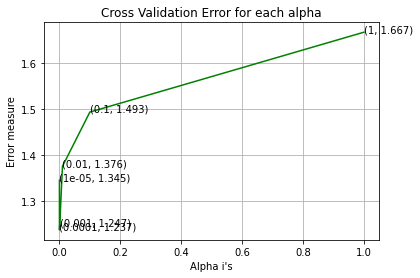

For values of best alpha =  0.0001 The train log loss is: 0.6721410382245755
For values of best alpha =  0.0001 The cross validation log loss is: 1.2373468193885961
For values of best alpha =  0.0001 The test log loss is: 1.0890818560166105


In [ ]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.013 % of word of test data appeared in train data
97.334 % of word of Cross Validation appeared in train data


## Machine Learning Models

In [ ]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55718)
(number of data points * number of features) in test data =  (665, 55718)
(number of data points * number of features) in cross validation data = (532, 55718)


In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## **Naive Bayes Model**

for alpha = 1e-05
Log Loss : 1.3057048350287017
for alpha = 0.0001
Log Loss : 1.2986909841915781
for alpha = 0.001
Log Loss : 1.2914284453653764
for alpha = 0.1
Log Loss : 1.2575243322799967
for alpha = 1
Log Loss : 1.2712912329140333
for alpha = 10
Log Loss : 1.346499942137567
for alpha = 100
Log Loss : 1.340829259743534
for alpha = 1000
Log Loss : 1.2920729846832988


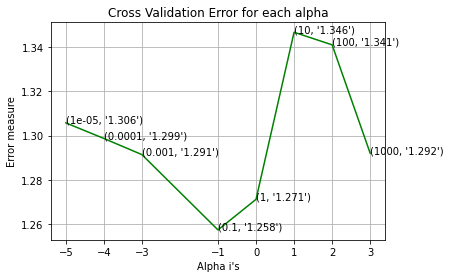

For values of best alpha =  0.1 The train log loss is: 0.8708146106108949
For values of best alpha =  0.1 The cross validation log loss is: 1.2575243322799967
For values of best alpha =  0.1 The test log loss is: 1.2713670614396861


In [ ]:


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.351653198716298
Number of missclassified point : 0.41729323308270677
-------------------- Confusion matrix --------------------


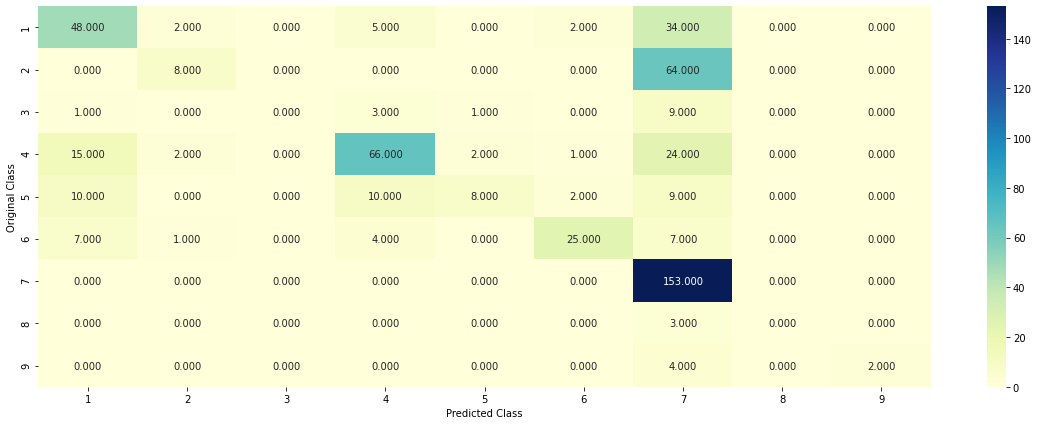

-------------------- Precision matrix (Column Sum=1) --------------------


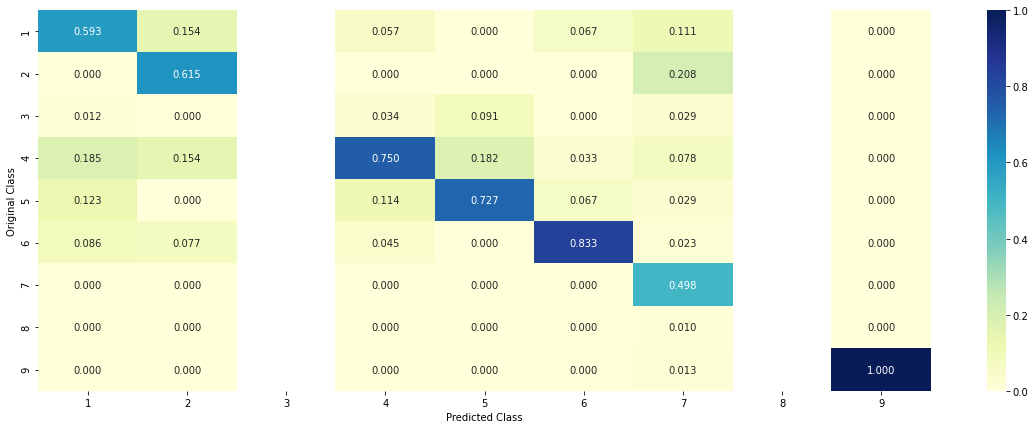

-------------------- Recall matrix (Row sum=1) --------------------


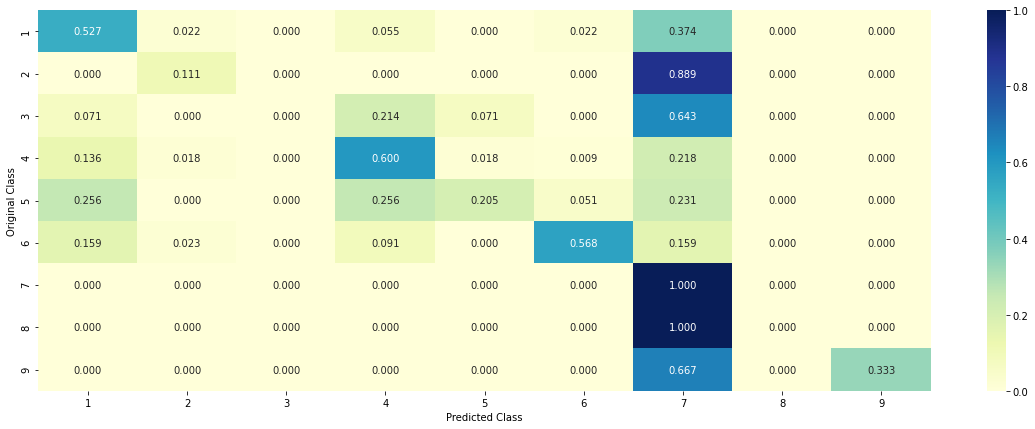

In [ ]:
#check Confusion matrix with best hyperparameter

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.1276 0.2198 0.036  0.1078 0.076  0.0656 0.3511 0.0065 0.0095]]
Actual Class : 6


#K Nearest Neighbour Classification

for alpha= 5
Log Loss : 0.975787682570851
for alpha= 11
Log Loss : 0.9540665542053606
for alpha= 15
Log Loss : 0.9525201481752206
for alpha= 21
Log Loss : 0.9731335462080296
for alpha= 31
Log Loss : 1.0057755061304978
for alpha= 41
Log Loss : 1.0233950955319029
for alpha= 51
Log Loss : 1.0350481621668324
for alpha= 99
Log Loss : 1.0457987107267601


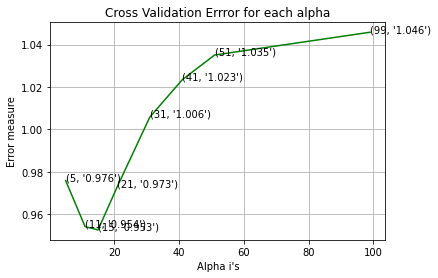

For values of best alpha =  15 The train log loss is: 0.6945803528639343
For values of best alpha =  15 The cross validation log loss is: 0.9525201481752206
For values of best alpha =  15 The test log loss is: 1.0424051713003204


In [ ]:
alpha = [5,11,15,21,31,41,51,99]
cv_log_error_array = []
for i in alpha:
    print("for alpha=", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels = clf.classes_, eps=1e-15))
    print("Log Loss :", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)),(alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Errror for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ',alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels = clf.classes_, eps = 1e-15))

#Testing the model with best hyper parameters

Log loss : 0.9525201481752206
Number of mis-classified points : 0.33270676691729323
-------------------- Confusion matrix --------------------


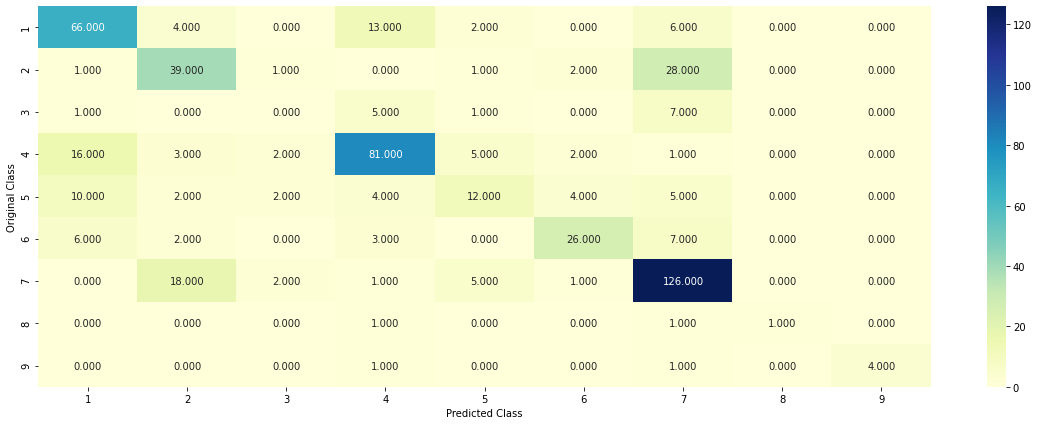

-------------------- Precision matrix (Column Sum=1) --------------------


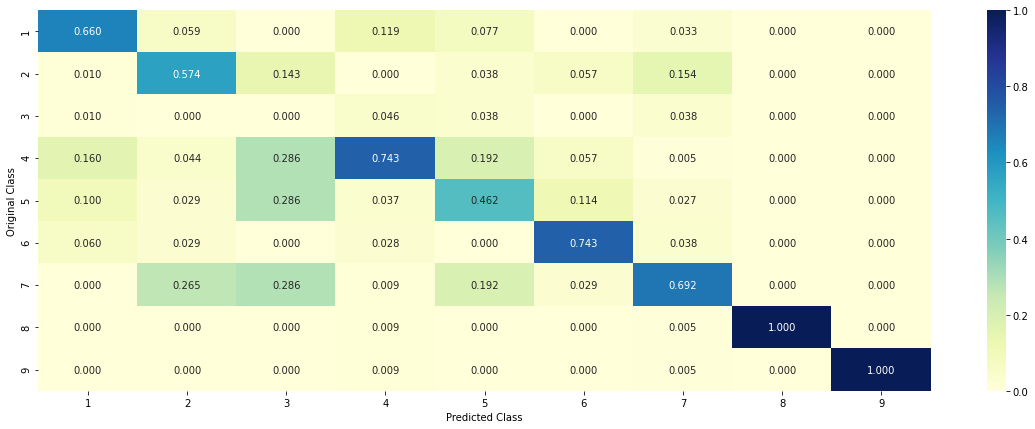

-------------------- Recall matrix (Row sum=1) --------------------


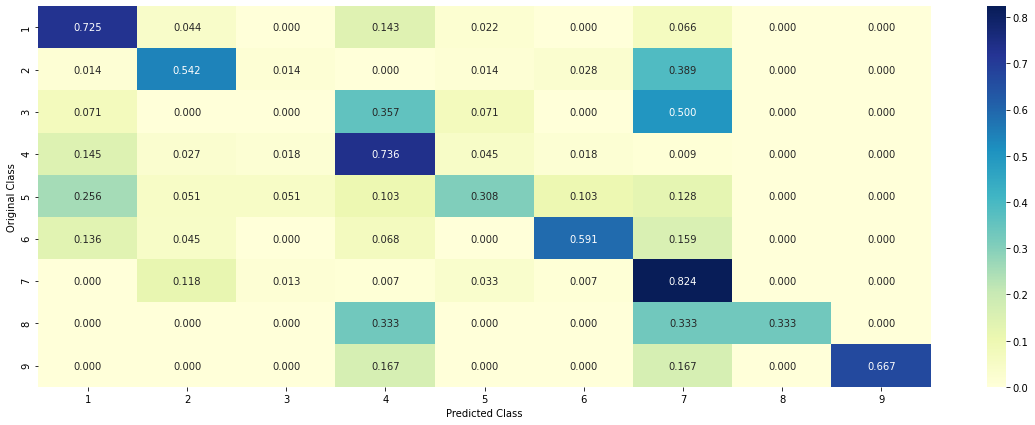

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding,cv_y, clf)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 20
predicted_cls = sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : [0.85753395 0.0237061  0.01094841 0.02323673 0.02557448 0.03663533
 0.01425982 0.00363713 0.00446805]
Actual Class : 1
The  15  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 6 1]
Fequency of nearest points : Counter({1: 14, 6: 1})


In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 20

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 6 1]
Fequency of nearest points : Counter({1: 14, 6: 1})


In [ ]:
print(neighbors)

In [ ]:
#Logistic Regression

For alpha = 1e-06
Log Loss : 1.307055036309853
For alpha = 1e-05
Log Loss : 1.2769087710445568
For alpha = 0.0001
Log Loss : 1.0647824330794988
For alpha = 0.001
Log Loss : 1.0278496807612025
For alpha = 0.01
Log Loss : 1.0843244277836654
For alpha = 0.1
Log Loss : 1.439876353966899
For alpha = 1
Log Loss : 1.6760889581411358
For alpha = 10
Log Loss : 1.7059825015319559
For alpha = 100
Log Loss : 1.7090759031486158


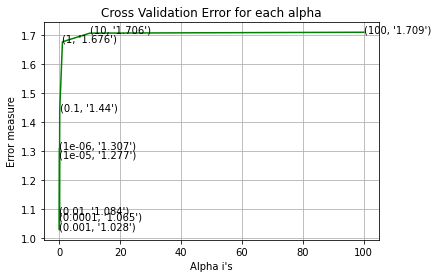

For values of best alpha =  0.001 The train log loss is: 0.5310335677965522
For values of best alpha =  0.001 The cross validation log loss is: 1.0278496807612025
For values of best alpoha =  0.001 The test log loss is: 1.068005965654817


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2',loss='log', random_state = 42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels = clf.classes_, eps=1e-15))
    print("Log Loss :", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = 'balanced', alpha = alpha[best_alpha], penalty = 'l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels = clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpoha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels = clf.classes_, eps=1e-15))

#Testing the model with best hyper parameters

Log loss : 1.0278496807612025
Number of mis-classified points : 0.32894736842105265
-------------------- Confusion matrix --------------------


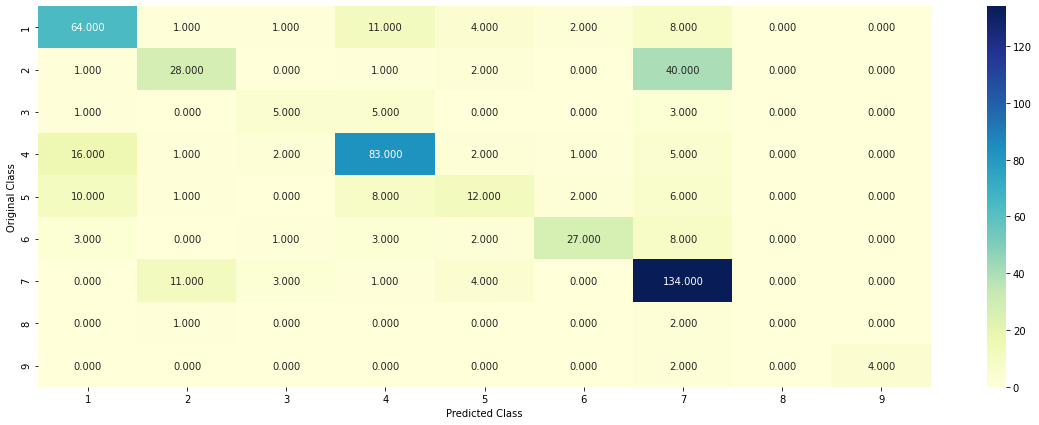

-------------------- Precision matrix (Column Sum=1) --------------------


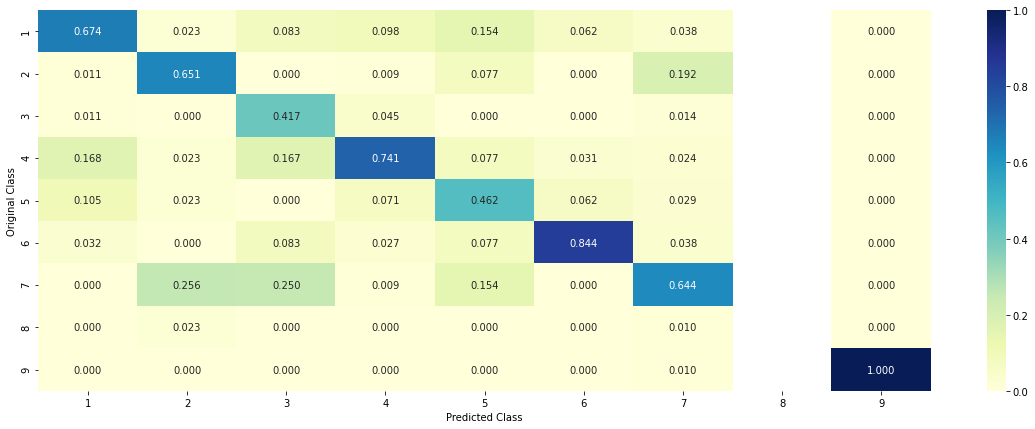

-------------------- Recall matrix (Row sum=1) --------------------


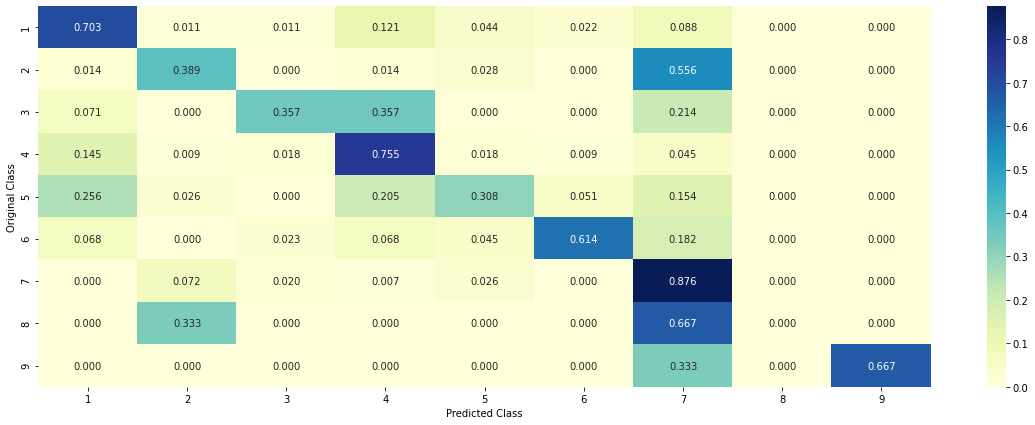

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#Without blanced data

for alpha = 1e-06
Log Loss : 1.30891093405602
for alpha = 1e-05
Log Loss : 1.2441631594407467
for alpha = 0.0001
Log Loss : 1.097820449104115
for alpha = 0.001
Log Loss : 1.0489376101234793
for alpha = 0.01
Log Loss : 1.1053452262683938
for alpha = 0.1
Log Loss : 1.341077971499734
for alpha = 1
Log Loss : 1.6055412490697285


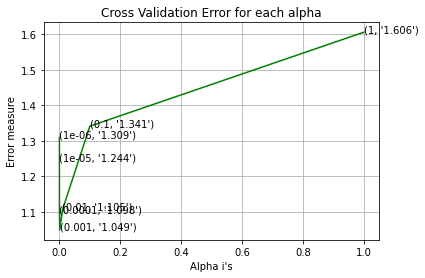

For values of best alpha =  0.001 The train log loss is: 0.5226589327749311
For values of best alpha =  0.001 The cross validation log loss is: 1.0489376101234793
For values of best alpha =  0.001 The test log loss is: 1.0852661152781735


In [ ]:


alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0489376101234793
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


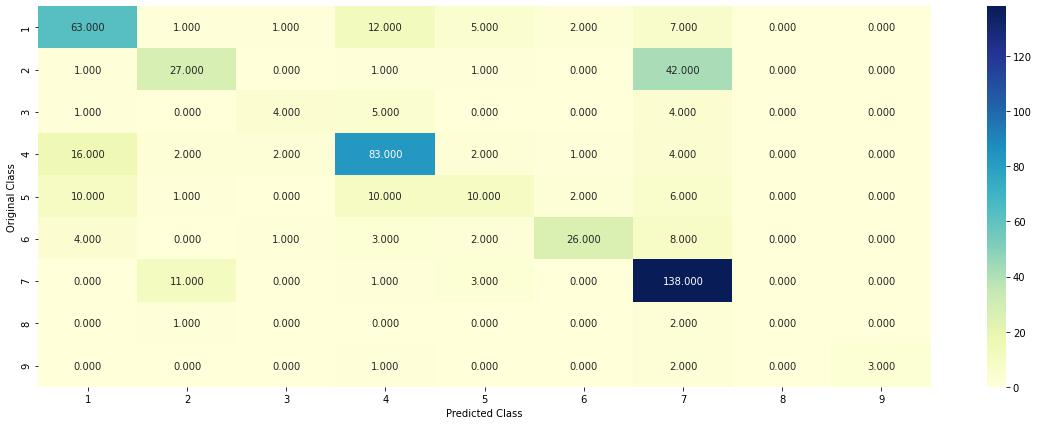

-------------------- Precision matrix (Column Sum=1) --------------------


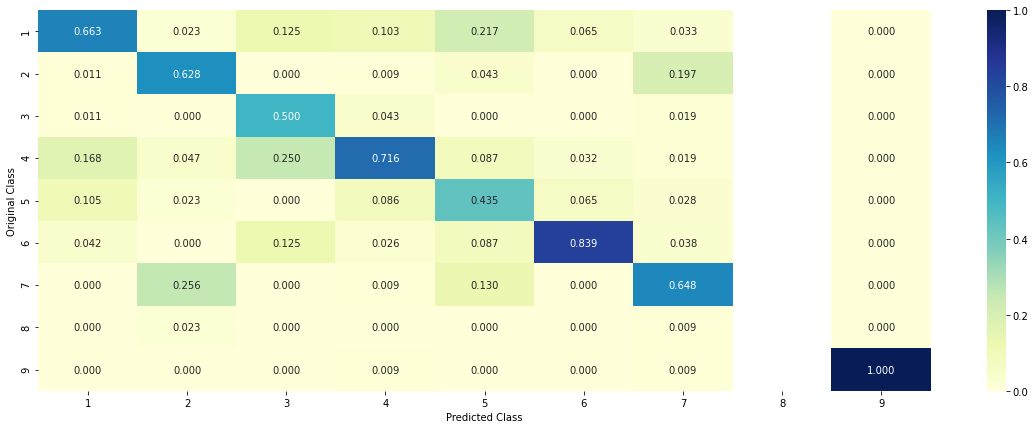

-------------------- Recall matrix (Row sum=1) --------------------


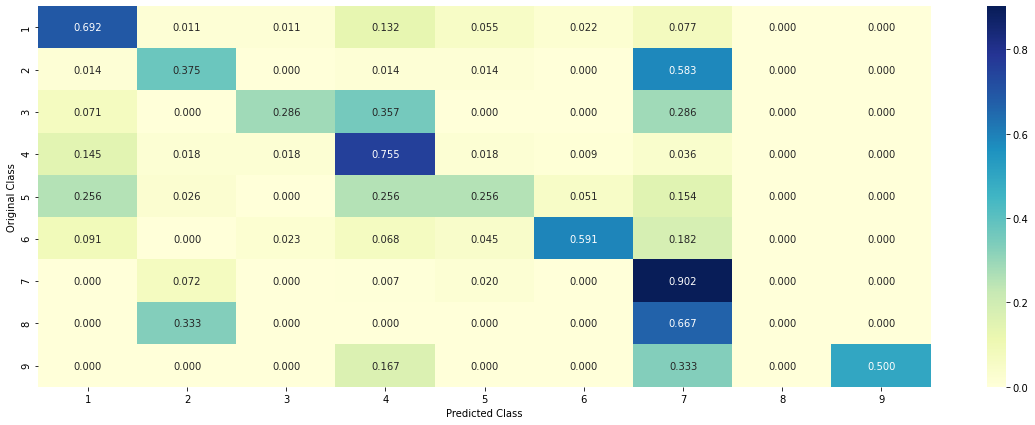

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#SVM Model

for C = 1e-05
Log Loss : 1.2949817898042868
for C = 0.0001
Log Loss : 1.1898501098736267
for C = 0.001
Log Loss : 1.1108096916398629
for C = 0.01
Log Loss : 1.1039379698210032
for C = 0.1
Log Loss : 1.3418888113411067
for C = 1
Log Loss : 1.692186801075737
for C = 10
Log Loss : 1.7095482340521875
for C = 100
Log Loss : 1.709548356096956


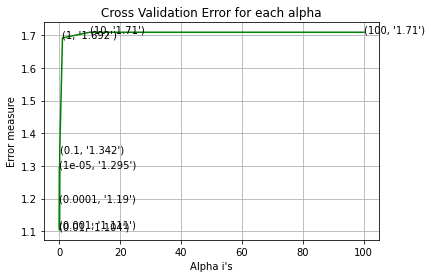

For values of best alpha =  0.01 The train log loss is: 0.7485129972871609
For values of best alpha =  0.01 The cross validation log loss is: 1.1039379698210032
For values of best alpha =  0.01 The test log loss is: 1.1571178412982532


In [ ]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1039379698210032
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


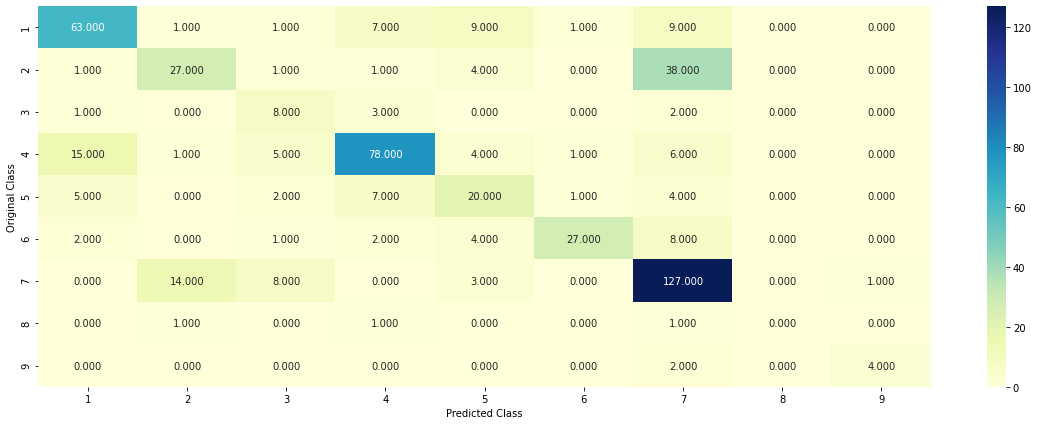

-------------------- Precision matrix (Column Sum=1) --------------------


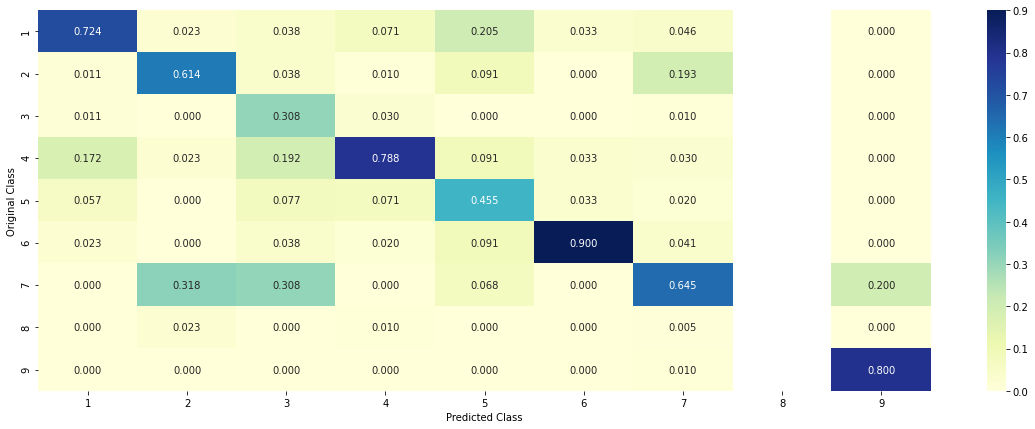

-------------------- Recall matrix (Row sum=1) --------------------


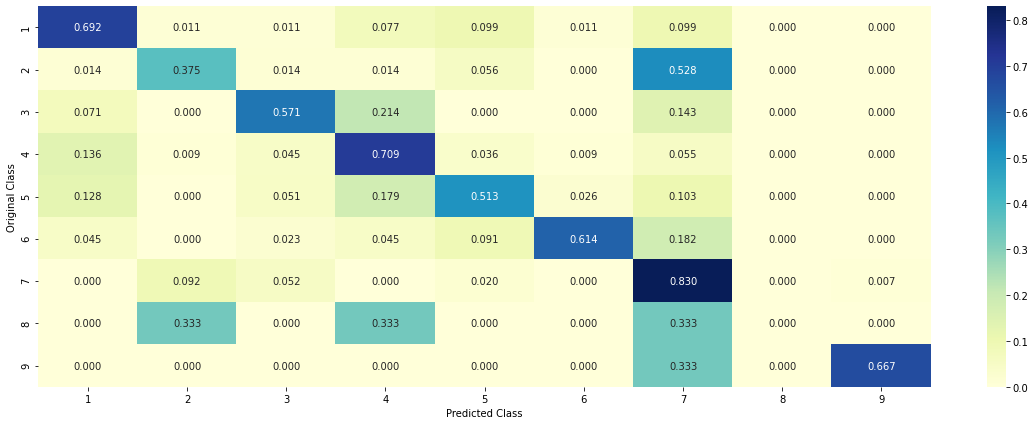

In [ ]:
clf  = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state = 42, class_weight = 'balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


#Random Forest Model

In [ ]:


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.262402684145501
for n_estimators = 100 and max depth =  10
Log Loss : 1.1813127380460302
for n_estimators = 200 and max depth =  5
Log Loss : 1.2531982410427638
for n_estimators = 200 and max depth =  10
Log Loss : 1.1754456838773053
for n_estimators = 500 and max depth =  5
Log Loss : 1.2473776425838154
for n_estimators = 500 and max depth =  10
Log Loss : 1.1666668825366588
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2472522219918525
for n_estimators = 1000 and max depth =  10
Log Loss : 1.165820987612581
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2458164595482324
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1650288354325757
For values of best estimator =  2000 The train log loss is: 0.6780005235429539
For values of best estimator =  2000 The cross validation log loss is: 1.1650288354325757
For values of best estimator =  2000 The test log loss is: 1.1308105566385889


In [ ]:
print(best_alpha)

9


In [ ]:
print(alpha[int(best_alpha/2)])

2000


Log loss : 1.1650288354325757
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


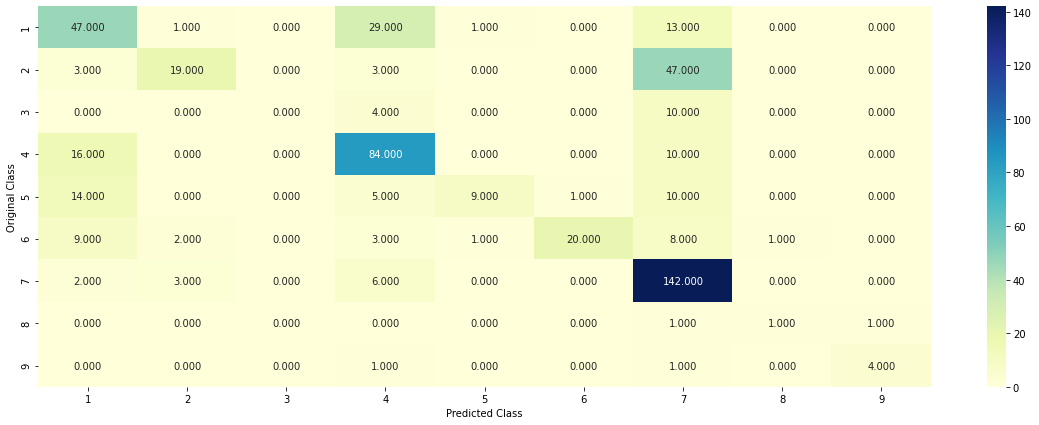

-------------------- Precision matrix (Column Sum=1) --------------------


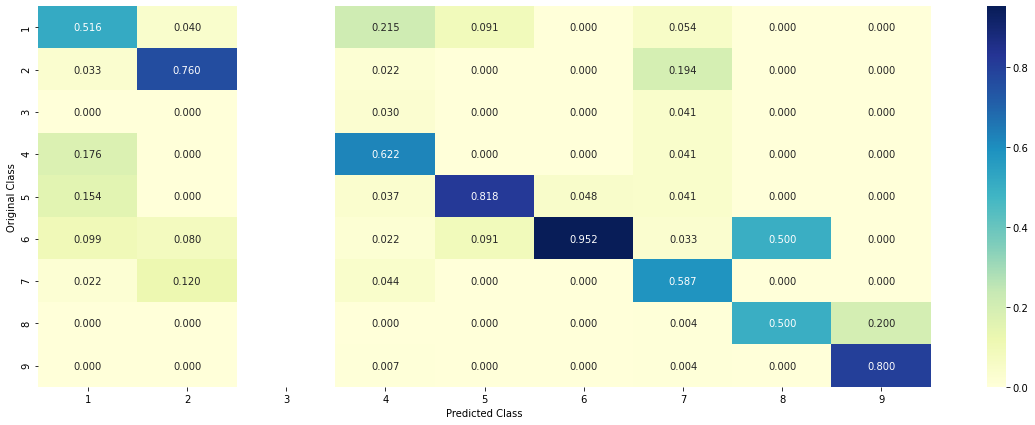

-------------------- Recall matrix (Row sum=1) --------------------


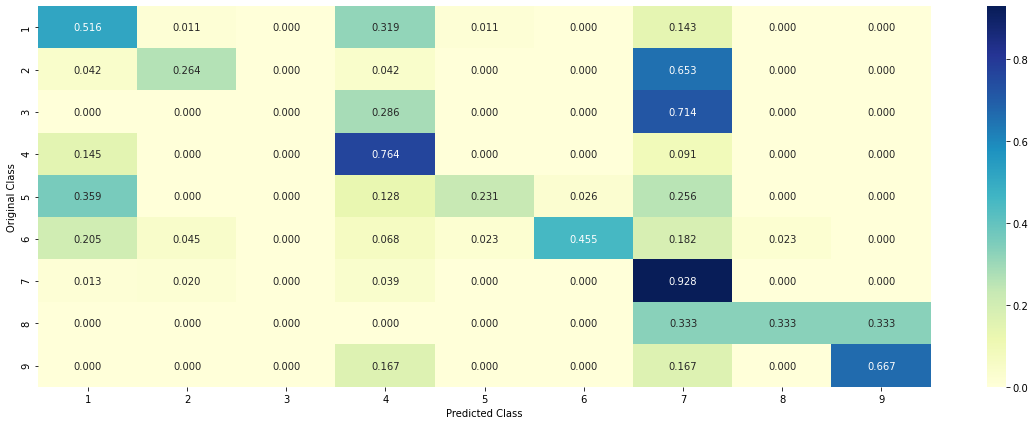

In [ ]:
clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)], criterion = 'gini', max_depth = max_depth[int(best_alpha%2)], random_state = 42, n_jobs=1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding, cv_y, clf)

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#Stacking models

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))

Logistic Regression :  Log Loss: 1.22
Support vector machines : Log Loss: 1.72
Naive Bayes : Log Loss: 1.34
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.728
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.374
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.286
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.600
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.971


Log loss (train) on the stacking classifier : 0.4943153916166427
Log loss (CV) on the stacking classifier : 1.2860590302277652
Log loss (test) on the stacking classifier : 1.1028245391258495
Number of missclassified point : 0.3398496240601504
-------------------- Confusion matrix --------------------


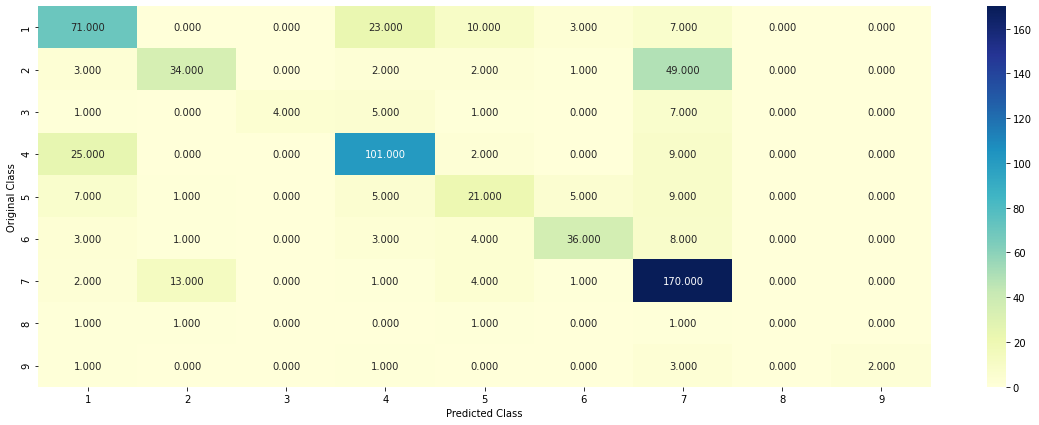

-------------------- Precision matrix (Column Sum=1) --------------------


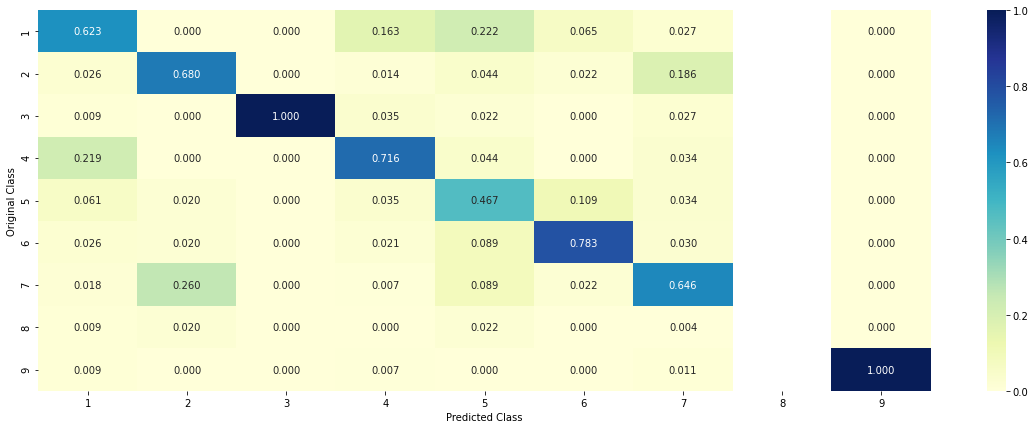

-------------------- Recall matrix (Row sum=1) --------------------


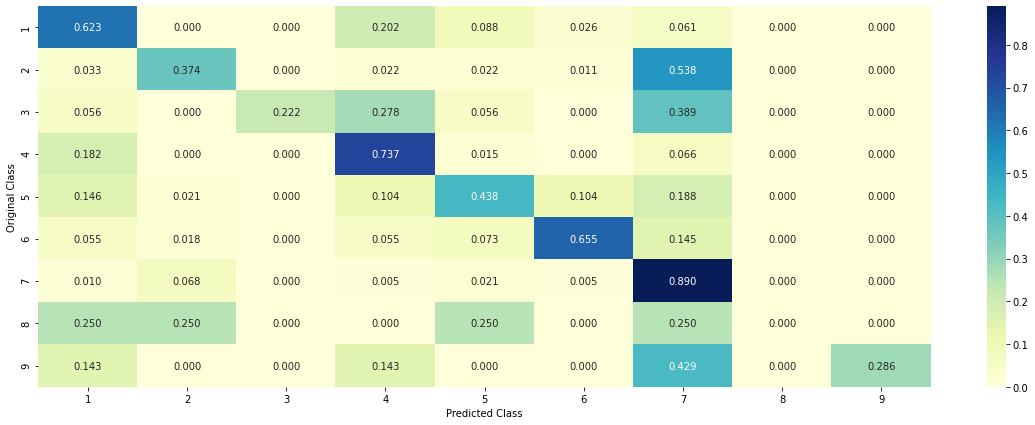

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximum Voting classifier

Log loss (train) on the VotingClassifier : 0.8711499095336247
Log loss (CV) on the VotingClassifier : 1.2399343335896191
Log loss (test) on the VotingClassifier : 1.162346710658989
Number of missclassified point : 0.34135338345864663
-------------------- Confusion matrix --------------------


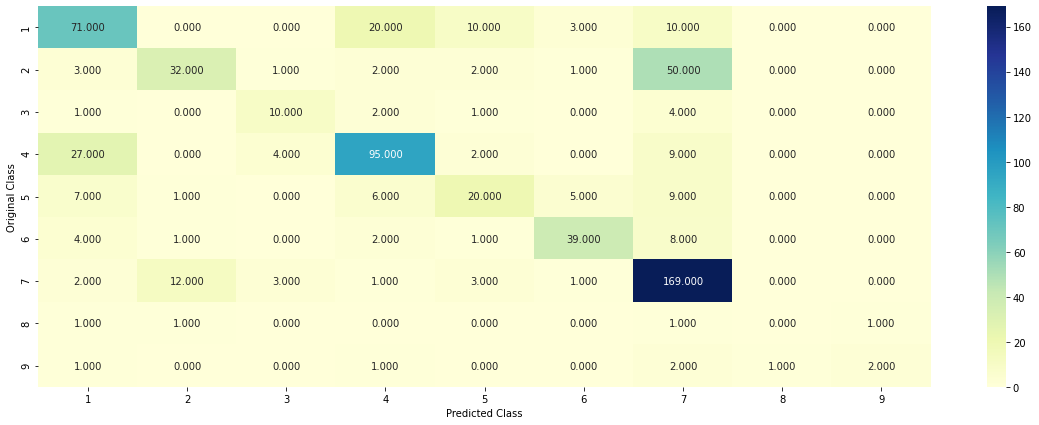

-------------------- Precision matrix (Column Sum=1) --------------------


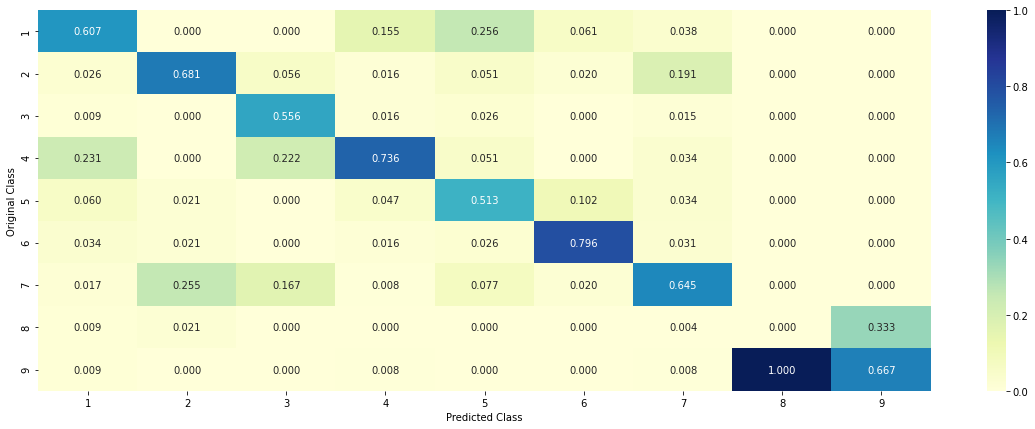

-------------------- Recall matrix (Row sum=1) --------------------


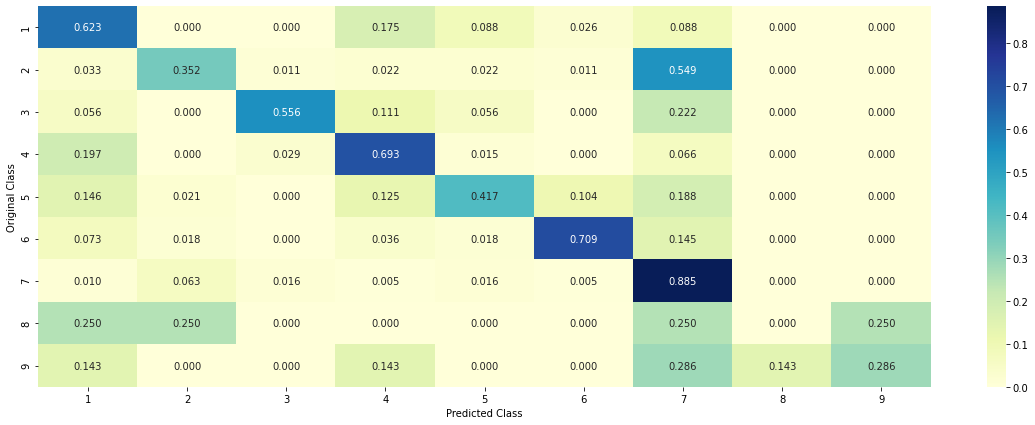

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))